# Random Forest Baseline

Train a RandomForestClassifier on the existing feature set for a tree-based baseline with cross-validation, holdout evaluation, and feature importance visualization.


In [1]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import balanced_accuracy_score


In [2]:
DATA_PATH = 'data/grandprix_features.csv'
CAT_COLS = [
    'driver_id',
    'constructor_id',
    'circuit_id',
]
NUM_COLS = [
    'grid_position',
    'quali_delta',
    'quali_tm_delta',
    'season_pts_driver',
    'season_pts_team',
    'last_3_avg',
    'is_street_circuit',
    'is_wet',
]
TARGET = 'points_scored'
data_path = Path(DATA_PATH)

df_model = pd.read_csv(data_path)
df_model[CAT_COLS] = df_model[CAT_COLS].fillna('unknown')
df_model[NUM_COLS] = df_model[NUM_COLS].fillna(0)
df_model[TARGET] = df_model[TARGET].fillna(0).astype(int)

print(f"Rows after cleaning: {len(df_model)}")
df_model.head()


Rows after cleaning: 1359


,driver_id,constructor_id,circuit_id,grid_position,quali_delta,quali_tm_delta,season_pts_driver,season_pts_team,last_3_avg,is_street_circuit,is_wet,points_scored
0,leclerc,ferrari,sakhir,1,0.000,-0.129,0.0,0.0,0.0,0,0,1
1,sainz,ferrari,sakhir,3,0.129,0.129,0.0,26.0,0.0,0,0,1
2,hamilton,mercedes,sakhir,5,0.490,-0.204,0.0,0.0,0.0,0,0,1
3,russell,mercedes,sakhir,9,0.694,0.204,0.0,15.0,0.0,0,0,1
4,magnussen,haas_f1_team,sakhir,7,0.903,-0.537,0.0,0.0,0.0,0,0,1


In [3]:
X = df_model[CAT_COLS + NUM_COLS]
y = df_model[TARGET]

preprocess = ColumnTransformer(
    [
        ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_COLS),
        ('num', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), NUM_COLS),
    ],
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((1087, 11), (272, 11))

In [4]:
# Random forest baseline (one-hot + imputer/scaler)
rf = make_pipeline(
    preprocess,
    RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight='balanced',
    ),
)

# Fit on training data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 (binary):', f1_score(y_test, y_pred))
print('F1 (macro):', f1_score(y_test, y_pred, average="macro"))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))


Precision: 0.8015267175572519
Recall: 0.7720588235294118
F1 (binary): 0.7865168539325843
F1 (macro): 0.7903703403236928
Balanced accuracy: 0.7904411764705883


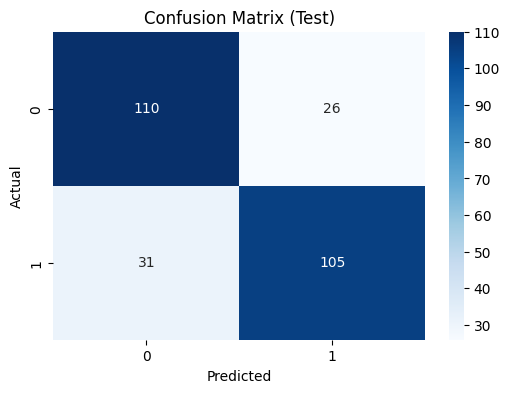

In [5]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
